# Homework exercise 3
## Deadline: upload to Moodle by 7 June 18:00 h

__Please submit your homework either as a Jupyter Notebook or using .py files.__

If you use .py files, please also include a PDF containing the output of your code and your explanations. Either way, the code needs to be in a form that can be easily run on another computer.

__Name 1:__Fabian Basler

__Name 2:__Evamaria Hammerschmid

__Name 3:__Julia Ornatowski


The name of the file that you upload should be named *Homework1_YourLastName_YourStudentID*.

Reminder: you are required to attend class on 26 May to earn points for this homework exercise unless you have a valid reason for your absence.

You are encouraged to work on this exercise in teams of up to three students. If any part of the questions is unclear, please ask on the Moodle forum.

#### APIs, NLP, ML


__Reddit__


The Reddit offers an API providing free access to up to 1000 submissions (i.e. posts), comments on those submissions, and some meta data. `PRAW` is a module that facilitates usage of the Reddit API, and it is recommended that you use it. It is documented at https://praw.readthedocs.io/en/latest/index.html and the Quick Start page should give you most of the information you need.

(If you would like to use more Reddit data, you may want to consider `PSAW`. You won't need it for this homework exercise, though it might be of interest if you'd like to use Reddit in your course project.)

Please note that using the Reddit API requires users to register. Feel free to use any temporary email address if you have any concerns with sharing your usual address with Reddit.

Please collect data for the top 1000 submissions and all the comments on those submissions for the subreddits 'wallstreetbets' and 'StockMarket'.

The goal will be to classify submissions, i.e., to predict which subreddit each submission belongs to. 

Write a class RedditClassifier that contains two object attributes: the categorical variable to be used in the classification (here: the subreddit) and a list (for now, since you have only encountered a binary classifier, of length 2) of values for that category (i.e. a list of the names of the two subreddits). The class should be derived from the Perceptron class from Chapter 7. It should contain a method that combines the preprocessing and the estimation.

The preprocessing should generate features that might help predict the category. Please don't use features such as the frequency of each word as we will take a look at appropriate ways of working with such information only in the next class. Possible features could be: length of title, number of comments, average sentence length, word length, number of sentences in the comments, shares of nouns, verbs, etc., number of stop words used compared to other words, etc.. Please add any other features that you think might be useful for this task but don't include features that are likely to perfectly predict the category (e.g. the author of a submission).

Please use this class to classify the submissions. Plot the percentage of submissions that are incorrectly classified in each epoch for different learning rates. Don't expect to achieve near-perfect predictions as the features you employ may not be able to easily distinguish between categories the way they did in the example in class.

In [114]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import nltk

subreddits = ["StockMarket", 'wallstreetbets']
reddit = praw.Reddit(
    client_id="cuDmFCTelGCG4w",
    client_secret="JJKHv_s7LlxkTKJE90xkPMiZIEqFRQ",
    user_agent="Homework3"
)

wallstreetbets=reddit.subreddit('wallstreetbets')
stockmarket=reddit.subreddit('StockMarket')


hot_stockmarket=stockmarket.hot(limit=1000)

hot_wsb=wallstreetbets.hot(limit=1000)

# values = [hot_stockmarket, hot_wsb]
# labels = ["StockMarket", 'wallstreetbets']

wsb_list = [submission for submission in hot_wsb]
stockmarket_list = [submission for submission in hot_stockmarket]
labels = ["stockmarket"]*len(stockmarket_list) +["wallstreetbets"]*len(wsb_list)
values = stockmarket_list + wsb_list



In [2]:
# for subred in values:
#     print(subred)

In [3]:
# for subred in values:
#     for submission in subred:
#         print(submission.id)

In [126]:
class Reddit_Perceptron(object):
    """Perceptron classifier.
    Parameters
    ------------
    eta : float
    Learning rate (between 0.0 and 1.0)
    n_iter : int
    Passes over the training dataset.
    random_state : int
    Random number generator seed for random weight
    initialization.
    Attributes
    -----------
    w_ : 1d-array
    Weights after fitting.
    errors_ : list
    Number of misclassifications (updates) in each epoch.
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        # self.X = X
        # self.y = y
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        # Member variables in Classifier for X and y (saves already preprocessed inputs)
        self.X = None
        self.y = None
    
    # def __iter__(self):
    #     return (subred for subred in self.X)
        

    def preprocessing(self, values, labels):
        titles=[]
        comment_count=[]
        comments=[]
        over_18=[]
        upvote_ratio=[]
        text=[]
        spoiler=[]
        lentitles=[]
        isself=[]
        subred=[]
        sentencecount=[]
        avgsentencelen=[]
        avgwordlen=[]
        avgwordlentext=[]
        #share_nouns=[]
        labels = np.array(labels)
        y = np.where(labels == 'wallstreetbets', -1, 1)
        print('Preprocessing Submissions.')
        for submission in tqdm(values):
            # print(submission.id)
            over_18.append(float(submission.over_18))
            upvote_ratio.append(submission.upvote_ratio)
            titles.append(submission.title)
            if submission.selftext=='': 
                text.append(0)
            else: 
                text.append(submission.selftext)
            spoiler.append(float(submission.spoiler))
            #Whether or not the submission is a selfpost (text-only).
            isself.append(float(submission.is_self))
            
            #Number of comments
            if submission.num_comments==0: 
                comment_count.append(0)
            else: 
                comment_count.append(float(submission.num_comments))


            total_com=0
            number_comments=0

            sentence_count_per_commment = []
            avg_wordlen_per_comment = []
            avg_sentencelen_per_commment = []

            for top_level_comment in submission.comments:
                if isinstance(top_level_comment, MoreComments):
                    continue

            #number of sentences in the comments
                count_sent=len(top_level_comment.body.split("."))
                sentence_count_per_commment.append(count_sent)

            #average sentence length
                num_words=len(top_level_comment.body.split(" "))
                avg_sentencelen_per_commment.append(num_words/count_sent)
            #average word length
                avg_wordlen_per_comment.append(len(top_level_comment.body)/num_words)
            #shares of nouns(analogue for verbs, stopwords), but loads so long and accurary was ok, so left out
            #tokenized = nltk.word_tokenize(top_level_comment.body)
            #nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
            #shares_nouns= len(nouns)/num_words
            #share_nouns.append((shares_nouns) if len(shares_nouns)>0 else 0)
            sentencecount.append(np.mean(sentence_count_per_commment) if len(sentence_count_per_commment) > 0 else 0)
            avgwordlen.append(np.mean(avg_wordlen_per_comment) if len(avg_wordlen_per_comment) > 0 else 0 )
            avgsentencelen.append(np.mean(avg_sentencelen_per_commment) if len(avg_sentencelen_per_commment) > 0 else 0)

        for title in titles:
            lentitles.append(len(title))
            
        for t in text:
            if t != 0:
                count=len(t.split(" "))
                avgwordlentext.append(len(t)/count)

            else:
                avgwordlentext.append(0)
        

        # for column in [titles, comment_count, comments,over_18,upvote_ratio,num_comments,text,spoiler,lentitles,isself]:
        #     print(len(column))
        data = pd.DataFrame(
        {'Comment Count':comment_count,
         'Over 18':over_18, 
         'Upvote Ratio':upvote_ratio, 
         'Spoiler':spoiler, 
         'Isself':isself,
         'Number of Sentences': sentencecount,
         'Avg. Number of words': avgwordlen,
         'Avg sentence length': avgsentencelen,
         'Average word lenth text': avgwordlentext
        })
        return data.values, y

  

    def fit(self, values, labels, force_preprocess = False):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
        y : array-like, shape = [n_samples]
        Target values.
        Returns
        -------
        self : object
        """
        # Check if input data is already preprocessed and stored in self.X and self.y
        if self.X is None or self.y is None or force_preprocess:
            self.X, self.y = self.preprocessing(values, labels)
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        self.error_rates_ = []
        print("Fitting Perceptron")
        for _ in tqdm(range(self.n_iter)):
            errors = 0
            for xi, target in zip(self.X, self.y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
            self.error_rates_.append(errors/len(X))
        return self


    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def predict(self,X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)


In [127]:
red_perceptron = Reddit_Perceptron()

In [128]:
red_perceptron.fit(values, labels)

Preprocessing Submissions.



Fitting Perceptron


Fitting Perceptron


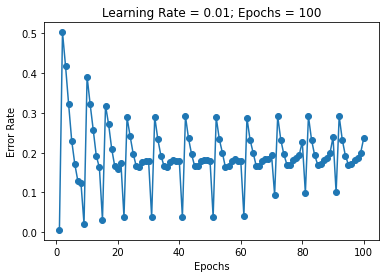

In [169]:
import matplotlib.pyplot as plt
red_perceptron.eta = 0.01
red_perceptron.n_iter = 100
red_perceptron.fit(values, labels)
plt.plot(range(1, len(red_perceptron.error_rates_) + 1), red_perceptron.error_rates_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.title(f'Learning Rate = {red_perceptron.eta}; Epochs = {red_perceptron.n_iter}')
plt.show()


Fitting Perceptron


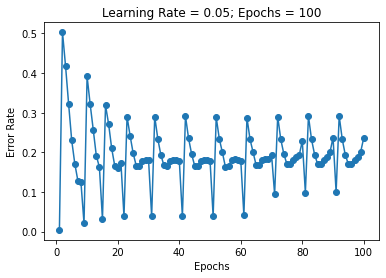

In [170]:
red_perceptron.eta = 0.05
red_perceptron.n_iter = 100
red_perceptron.fit(values, labels)
plt.plot(range(1, len(red_perceptron.error_rates_) + 1), red_perceptron.error_rates_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.title(f'Learning Rate = {red_perceptron.eta}; Epochs = {red_perceptron.n_iter}')
plt.show()

Fitting Perceptron


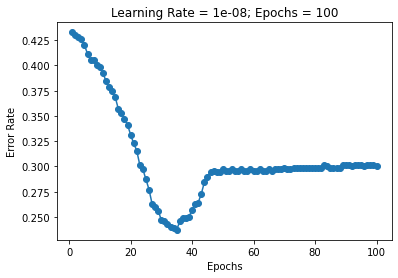

In [171]:
red_perceptron.eta = 0.00000001
red_perceptron.n_iter = 100
red_perceptron.fit(values, labels)
plt.plot(range(1, len(red_perceptron.error_rates_) + 1), red_perceptron.error_rates_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.title(f'Learning Rate = {red_perceptron.eta}; Epochs = {red_perceptron.n_iter}')
plt.show()

Fitting Perceptron


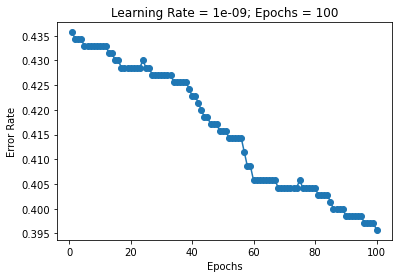

In [172]:
red_perceptron.eta = 0.000000001
red_perceptron.n_iter = 100
red_perceptron.fit(values, labels)
plt.plot(range(1, len(red_perceptron.error_rates_) + 1), red_perceptron.error_rates_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.title(f'Learning Rate = {red_perceptron.eta}; Epochs = {red_perceptron.n_iter}')
plt.show()